In [20]:
import pandas as pd
import re
# from tqdm.auto import tqdm
from tqdm.notebook import tqdm
import yfinance as yf
# import swifter
import numpy as np
from collections import OrderedDict

#載入PCA套件
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import matplotlib.colors as colors
plt.rcParams['font.sans-serif'] = ['SimHei'] # 修改中文字體
plt.rcParams['axes.unicode_minus'] = False # 顯示負號

import quantstats as qs

from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
'''加入產業'''
raw_sector = pd.read_excel('Data/TEJ_產業別.xlsx')

filter = (raw_sector['上市別'] == 'OTC') | (raw_sector['上市別'] == 'TSE')
raw_sector = raw_sector[filter]
raw_sector['codes'] = raw_sector.apply(lambda x: x['代號'] + '.TW' if x['上市別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
raw_sector = raw_sector[['名稱','codes','TSE新產業_名稱']]

sectors = list(set(raw_sector['TSE新產業_名稱']))

raw_sector = raw_sector.reset_index(drop = True)

In [3]:
# command = ''
# for i in range(0,len(raw_sector['codes'])):
#     command += raw_sector['codes'][i]+' '
    

# raw_data = yf.download(command)['Close']
# raw_data.to_csv('Data2/raw_data.csv')

raw_data = pd.read_csv('Data2/raw_data.csv', index_col = 0)
time_index = pd.to_datetime(raw_data.index)
stock_column = raw_data.columns

In [4]:
value = pd.read_excel('Data2/PB_Value.xlsx')
filter = (value['市場別'] == 'OTC') | (value['市場別'] == 'TSE')
value  = value[filter]
value['codes'] = value.apply(lambda x: x['代號'] + '.TW' if x['市場別'] == 'TSE' else x['代號'] + '.TWO', axis = 1)
value['財報發布日'] = pd.to_datetime(value['財報發布日'])

In [5]:
tmp_index = list(time_index)
for tmp in tqdm(value['財報發布日']):
    if tmp not in tmp_index:
        tmp_index.append(tmp)
tmp_index.sort()

  0%|          | 0/112260 [00:00<?, ?it/s]

In [6]:
raw_df_value = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['季底普通股市值']
    raw_df_value = raw_df_value.join(tmp_[stock_column[i]]).ffill()
    
raw_df_value['time'] = raw_df_value.index
raw_df_value['type'] = raw_df_value.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_value = raw_df_value[raw_df_value['type'] == 1]

del raw_df_value['time']
del raw_df_value['type']
raw_df_value = raw_df_value['2008':]
# raw_df_value.index = raw_df_value.index.astype(str)

  0%|          | 0/1817 [00:00<?, ?it/s]

In [7]:
raw_df_PB = pd.DataFrame(index = tmp_index)
for i in tqdm(range(0,len(stock_column))):
    tmp = value[value['codes'] == stock_column[i]][['財報發布日','季底普通股市值','每股淨值(C)','季底每股稅前淨利']]
    tmp.index = tmp['財報發布日'].values
    tmp = tmp.sort_index()
    tmp = tmp.drop_duplicates(subset = '財報發布日',keep = 'last')

    tmp_ = pd.DataFrame()
    tmp_[stock_column[i]] = tmp['每股淨值(C)']
    raw_df_PB = raw_df_PB.join(tmp_[stock_column[i]]).ffill()
    
raw_df_PB['time'] = raw_df_PB.index
raw_df_PB['type'] = raw_df_PB.apply(lambda x: 1 if x.time in time_index else 0, axis = 1)
raw_df_PB = raw_df_PB[raw_df_PB['type'] == 1]

del raw_df_PB['time']
del raw_df_PB['type']
raw_df_PB = raw_df_PB['2008':]

  0%|          | 0/1817 [00:00<?, ?it/s]

In [8]:
def process(VALUE_RANK, VALUE_RANK_N, T, N, DAYS):
    raw_return = raw_data.pct_change()['2008':]
    weighted_df = np.multiply(raw_return,raw_df_value)
    weighted_df = weighted_df['2008':]

    for sector in sectors:
        raw_sector[raw_sector['TSE新產業_名稱'] == sector]

    # sectors_df = pd.DataFrame()
    # for i in range(0,len(sectors)):
    #     tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    #     tmp_ = weighted_df[tmp].mean(axis = 1)
    #     sectors_df[sectors[i]] = tmp_

    '''一開始再篩的時候，就篩市值'''
    sectors_df = pd.DataFrame()
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        tmp_ = np.multiply(weighted_df[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)).mean(axis = 1)
        sectors_df[sectors[i]] = tmp_

    half_life = list((1/2)**(np.arange(T,0,-1)/T))
    rolling_sectors_df = pd.DataFrame(sectors_df.rolling(T))

    #輸入有多少成分我們想要留住分解
    pca = PCA(n_components = N)

    dates = []
    centralities = {}
    absorption_ratios_list = []
    absorption_ratios_time = []
    for i in tqdm(range(T, len(rolling_sectors_df))):
    # for i in range(T, T+5):
        df = rolling_sectors_df.iloc[i,0].mul(half_life, axis = 0)
        date = df.index[-1]
        
        #將資料分成兩個主成份
        X = df.cov()
        pca.fit(X)
        x_pca = pca.transform(X)

        # 主成份的解釋力
        absorption_ratios = pca.explained_variance_ratio_
        absorption_ratios_list.append(absorption_ratios[0:1])
        absorption_ratios_time.append(date)
        # 各產業集中度
        # centralities = {'產業集中度':[]}
        centralities[date] = []
        for i in range(len(x_pca)):
            eigien_ratio = 0
            for j in range(0,N):
                eigien_ratio += (np.abs(x_pca[i,j])/ np.abs(x_pca.T[j]).sum())*absorption_ratios[j]
            centrality = eigien_ratio/absorption_ratios.sum()
            centralities[date].append(centrality)
            
    centralities = pd.DataFrame(centralities)
    centralities.index = df.keys()
    centralities = centralities.T

    standard_centralities = (centralities - centralities.rolling(DAYS).mean())/centralities.rolling(DAYS).std()

    cmap = colors.LinearSegmentedColormap.from_list("brw", ["white", "blue", "red"], N = len(sectors))

    # rank_centralities = centralities.rank(axis = 1, ascending = False).T
    rank_centralities = standard_centralities['2012':].rank(axis = 1, ascending = False)

    PB_ratio = np.multiply(raw_data['2008':],1/raw_df_PB)

    PB_sector = pd.DataFrame()
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        tmp_ = PB_ratio[tmp].sum(axis = 1)
        PB_sector[sectors[i]] = tmp_

    tmp = PB_sector/PB_sector.rolling(DAYS).mean()
    PB_star = pd.DataFrame()
    for sector in list(PB_sector.columns):
        columns = list(PB_sector.columns)
        columns.remove(sector)
        PB_star[sector] = tmp[sector]/(tmp[columns]).mean(axis = 1)

    '''PB ratio'''

    rank_PB_star = PB_star['2012':].rank(axis = 1, ascending = False)


    '''交易'''
    sectors_df = pd.DataFrame()
    VALUE_RANK = 1
    for i in range(0,len(sectors)):
        tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
        if VALUE_RANK == 0 :
            tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1)< round(len(tmp)*VALUE_RANK_N)).mean(axis = 1)
            # tmp_ = raw_return[tmp].mean(axis = 1)
        else:
            tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)).mean(axis = 1)
        sectors_df[sectors[i]] = tmp_
        # print(round(len(tmp)*VALUE_RANK_N))
    print('finish process')

    absorption_ratios_list = [tmp[0] for tmp in absorption_ratios_list]
    absorption_ratios_df = pd.DataFrame(absorption_ratios_list, index = absorption_ratios_time)

    return raw_return, rank_PB_star,PB_star, rank_centralities, sectors_df, absorption_ratios_df, centralities,standard_centralities

In [9]:
def get_results(result_type, rank_PB_star, rank_centralities, DB_new, RANK_RESULT):
    
    if result_type == 1:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 2:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities > RANK_RESULT

    elif result_type == 4:
        rank_PB_star_bool = rank_PB_star <= RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    elif result_type == 3:
        rank_PB_star_bool = rank_PB_star > RANK_RESULT
        rank_centralities_bool = rank_centralities <= RANK_RESULT

    bool_df = (rank_PB_star_bool*rank_centralities_bool).shift(1)
    

    DB_new = DB_new*bool_df
    yearly_return = ((DB_new*bool_df).sum(axis = 1)/bool_df.sum(axis = 1))*252

    return bool_df, DB_new, yearly_return

In [10]:
VALUE_RANK_s = [0.1]# 取percentile
VALUE_RANK_N = 5 # 取前幾名
T = 125 # 半衰期
N = 2 # PCA 成分
DAYSs = [252*3] # PCA & PB
RANK_RESULTs = [5]


for VALUE_RANK in tqdm(VALUE_RANK_s):
# for VALUE_RANK_N in tqdm(VALUE_RANK_Ns):
    for DAYS in DAYSs:
        for RANK_RESULT in RANK_RESULTs:
            raw_return, rank_PB_star, PB_star, rank_centralities, sectors_df, absorption_ratios_df, centralities,standard_centralities = process(VALUE_RANK, VALUE_RANK_N, T , N, DAYS)

            df_results = pd.DataFrame()

            bool_no_b_1, no_b_1, df_results['no bubble_1'] = get_results(result_type = 1, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_no_b_2, no_b_2, df_results['no bubble_2'] = get_results(result_type = 2, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_b_r, b_r, df_results['bubble runup'] = get_results(result_type = 3, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)
            bool_b_s, b_s, df_results['bubble selloff'] = get_results(result_type = 4, rank_PB_star = rank_PB_star, rank_centralities = rank_centralities, DB_new = sectors_df['2012':], RANK_RESULT = RANK_RESULT)

            pd.DataFrame(df_results.fillna(0).mean()).to_csv('Data2/Result/'f'daily_results_mean_{VALUE_RANK}_{VALUE_RANK_N}_{T}_{DAYS}_{RANK_RESULT}.csv')

            df = b_r.sum(axis = 1)/bool_b_r.sum(axis = 1)
            df.index = pd.to_datetime(df.index)
            # qs.reports.full(df)

            tmp = qs.reports.metrics(df, display = False)
            tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{VALUE_RANK_N}_{T}_{DAYS}_{RANK_RESULT}.xlsx', index = False)

            

  0%|          | 0/1 [00:00<?, ?it/s]

/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series wil

  0%|          | 0/3880 [00:00<?, ?it/s]

/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/ipykernel_launcher.py:96: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy a

finish process


In [11]:
# 大盤
# market = yf.download('^TWII')['Close']
market = pd.read_csv('market.csv', index_col = 'Date')['Close']
market.index = pd.to_datetime(market.index)
market_return = market[market.index > pd.to_datetime('2011-01-01')].pct_change()

In [12]:
from pypfopt import black_litterman, risk_models

In [13]:
import math
from pypfopt.black_litterman import BlackLittermanModel
VALUE_RANK = 0.1

sectors_df_mcap = pd.DataFrame() # 拿來評估的
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)

    tmp__ = raw_df_value[tmp].rank(axis = 1) < round(len(tmp)*VALUE_RANK)
    tmp__ = tmp__.applymap(lambda x: 1 if x == True else 0)
    tmp__['total'] = tmp__.sum(axis = 1)
    
    for col in tmp__.columns:
        tmp__[col] = tmp__[col]/tmp__['total']
    del tmp__['total']
    tmp_ = np.multiply(raw_df_value[tmp], tmp__).mean(axis = 1)

    sectors_df_mcap[sectors[i]] = tmp_

sectors_df = pd.DataFrame()
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    tmp_ = raw_return[tmp].mean(axis = 1)
    sectors_df[sectors[i]] = tmp_

sectors_df_return = pd.DataFrame() # 拿來交易的
sectors_df_return_norank = pd.DataFrame()
bl_asset_df = pd.DataFrame()
# for i in range(0,1):
for i in range(0,len(sectors)):
    tmp = list(raw_sector[raw_sector['TSE新產業_名稱'] == sectors[i]]['codes'].values)
    if VALUE_RANK == 0 :
        tmp_ = np.multiply(raw_return[tmp], raw_df_value[tmp].rank(axis = 1) < math.ceil(len(tmp)*VALUE_RANK_N)).mean(axis = 1)
    else:
        tmp__ = raw_df_value[tmp].rank(axis = 1) <= math.ceil(len(tmp)*VALUE_RANK)
        # tmp__ = raw_df_value[tmp].rank(axis = 1) <= 1
        tmp__ = tmp__.applymap(lambda x: 1 if x == True else 0)

        bl_asset = []
        for j in range(0,len(tmp__)):
            bl_asset.append(list(tmp__.iloc[j][tmp__.iloc[j] != 0].index))
        
        tmp__['total'] = tmp__.sum(axis = 1)
        
        for col in tmp__.columns:
            tmp__[col] = tmp__[col]/tmp__['total']
        del tmp__['total']
        tmp_ = np.multiply(raw_return[tmp], tmp__).sum(axis = 1)
        tmp_a = raw_return[tmp].mean(axis = 1)

    sectors_df_return[sectors[i]] = tmp_
    sectors_df_return_norank[sectors[i]] = tmp_a
    bl_asset_df[sectors[i]] = bl_asset
    bl_asset_df.index = sectors_df_return_norank.index

/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/ipykernel_launcher.py:48: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.


In [22]:
type_df = bool_no_b_1.applymap(lambda x: 1 if x == True else 0) + bool_no_b_2.applymap(lambda x: 2 if x == True else 0) + bool_b_r.applymap(lambda x: 3 if x == True else 0) + bool_b_s.applymap(lambda x: 4 if x == True else 0)
type_df = type_df[1:]
prior_results = pd.DataFrame(type_df.groupby(sectors))

weights_df = pd.DataFrame()
# for i in tqdm(range(0,10)):
for i in tqdm(range(0,len(type_df))):
    # print(type_df.iloc[i].name)

    mcaps = sectors_df_mcap[sectors_df_mcap.index < type_df.iloc[i].name].iloc[-1].to_dict()
    cov_matrix = sectors_df[sectors_df.index < type_df.iloc[i].name].cov()
    market_prices = market[market.index < type_df.iloc[i].name]
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

    tmp = prior_results.iloc[prior_results[1][prior_results[0] == tuple(type_df.iloc[i].values)].index[0],1]
    tmp = tmp[tmp.index < type_df.iloc[i].name]
    mkt = market_prices[market_prices.index < type_df.iloc[i].name]
    tmp_results = pd.DataFrame(sectors_df_return.loc[list(tmp.index)].mean(),columns = ['過去報酬']).T

    Q = tmp_results.fillna(0).values[0].reshape(-1, 1)

    tmp_p = np.array([[0]*len(Q)]*len(Q))
    for j in range(0,len(tmp_p)):
        tmp_p[j][j] = 1
    P = tmp_p

    bl = BlackLittermanModel(cov_matrix, Q = Q, P = P)

    rets = bl.bl_returns()
    ef = EfficientFrontier(rets, cov_matrix)

    # OR use return-implied weights
    delta = black_litterman.market_implied_risk_aversion(market_prices)
    bl.bl_weights(delta)
    weights = bl.clean_weights()

    df = pd.DataFrame([k for k in weights.values()], index = weights.keys(), columns = [type_df.iloc[i].name]).T
    weights_df = pd.concat([weights_df,df])

weights_df[weights_df < 0] = 0
tmp = weights_df.sum(axis = 1)
for col in weights_df.columns:
    weights_df[col] = weights_df[col]/tmp

df = ((weights_df).ffill().shift(1)*sectors_df_return['2012':]).sum(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_BL'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'daily_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)


## Monthly
date = []
new_weights_df = weights_df.ffill().copy()
new_weights_df.index = pd.to_datetime(new_weights_df.index)
for i, j in weights_df.groupby([new_weights_df.index.year,new_weights_df.index.month]):
# for i, j in tmp_df.groupby([tmp_df.index.year,tmp_df.index.week]):
    date.append(j.index[0]) #每個禮拜第一交易日

new_weights_df.index = new_weights_df.index.astype(str)
for i in range(0,len(weights_df)):
    if new_weights_df.iloc[i].name not in date:
        new_weights_df.iloc[i] = np.NaN
new_weights_df = new_weights_df.ffill()

df = (new_weights_df*sectors_df_return['2012':]).sum(axis = 1)
df.index = pd.to_datetime(df.index)

# qs.reports.full(df['2012':], benchmark = market_return['2012':])
METHOD = 'rank_BL'
tmp = qs.reports.metrics(df['2020':], display = False)
tmp.to_excel('Data2/Result/'f'monthly_performance_{VALUE_RANK}_{METHOD}.xlsx', index = False)

  0%|          | 0/3007 [00:00<?, ?it/s]

/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/pypfopt/black_litterman.py:257: UserWarning: Running Black-Litterman with no prior.
  warnings.warn("Running Black-Litterman with no prior.")
/home/cc/miniconda3/envs/Paper/lib/python3.7/site-packages/pypfopt/black_litterman.py:451: RuntimeWarning: invalid value encountered in true_divide
  self.weights = raw_weights / raw_weights.sum()


# Month

In [23]:
bl_weight = new_weights_df 

profit_bool_bl_weight = bl_weight
tmp = []
tmp__ = []
stock_weights_ = []
for i in tqdm(range(0,len(profit_bool_bl_weight))):
    tmp.append(profit_bool_bl_weight.iloc[i][profit_bool_bl_weight.iloc[i] != 0].index.values) ## sector!=0
    if len(tmp[-1]) > 0 :
        tmp_ = []
        stock_weights = []
        for j in range(0,len(tmp[-1])):
            # tmp_.append(raw_sector['codes'][raw_sector['TSE新產業_名稱'] == tmp[-1][j]].values)
            tmp_.append(bl_asset_df[tmp[-1]].iloc[i].values[j]) # stock name
            sector_weight = profit_bool_bl_weight.iloc[i][profit_bool_bl_weight.iloc[i] != 0][j]
            stock_num = len(bl_asset_df[tmp[-1]].iloc[i].values[j])
            stock_weight = [sector_weight/stock_num]*stock_num
            stock_weights.append(stock_weight)

    else:
        tmp_ = ['']
        stock_weight = ['']
    tmp__.append(tmp_)
    stock_weights_.append(stock_weights)
 

profit_bool_bl_weight['投資產業'] = tmp
profit_bool_bl_weight['投資Stock'] = tmp__
profit_bool_bl_weight['Stcok Weight'] = stock_weights_

test = 0
for i in range(0,len(profit_bool_bl_weight['Stcok Weight'].iloc[-1])):
    # np.sum(stock_weights[i])
    test+=np.sum(stock_weights[i])

summary_bl_asset = pd.DataFrame(index = profit_bool_bl_weight.index, columns = raw_data.columns)
test = []
for i in range(0,len(summary_bl_asset)):
    tmp = []
    for stock in profit_bool_bl_weight['投資Stock'].iloc[i]:
        tmp.extend(stock)
    
    tmp_ = []
    for stock in profit_bool_bl_weight['Stcok Weight'].iloc[i]:
        tmp_.extend(stock)

    test.extend(tmp)
    summary_bl_asset.iloc[i][tmp] = tmp_

  0%|          | 0/3007 [00:00<?, ?it/s]

In [24]:
fee = 0.001425
tax = 0.003
summary_bl_asset = summary_bl_asset.shift(1)
cost_basic = summary_bl_asset.diff().fillna(0)
cost_basic = cost_basic.applymap(lambda x: fee if x>0 else ((fee+tax) if x<0 else x) )
df_real = (summary_bl_asset*(raw_return['2012-01-03':]- cost_basic)).sum(axis = 1)
df_bl = (summary_bl_asset*(raw_return['2012-01-03':])).sum(axis = 1)

benchmark = yf.download('0050.TW')['Adj Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed


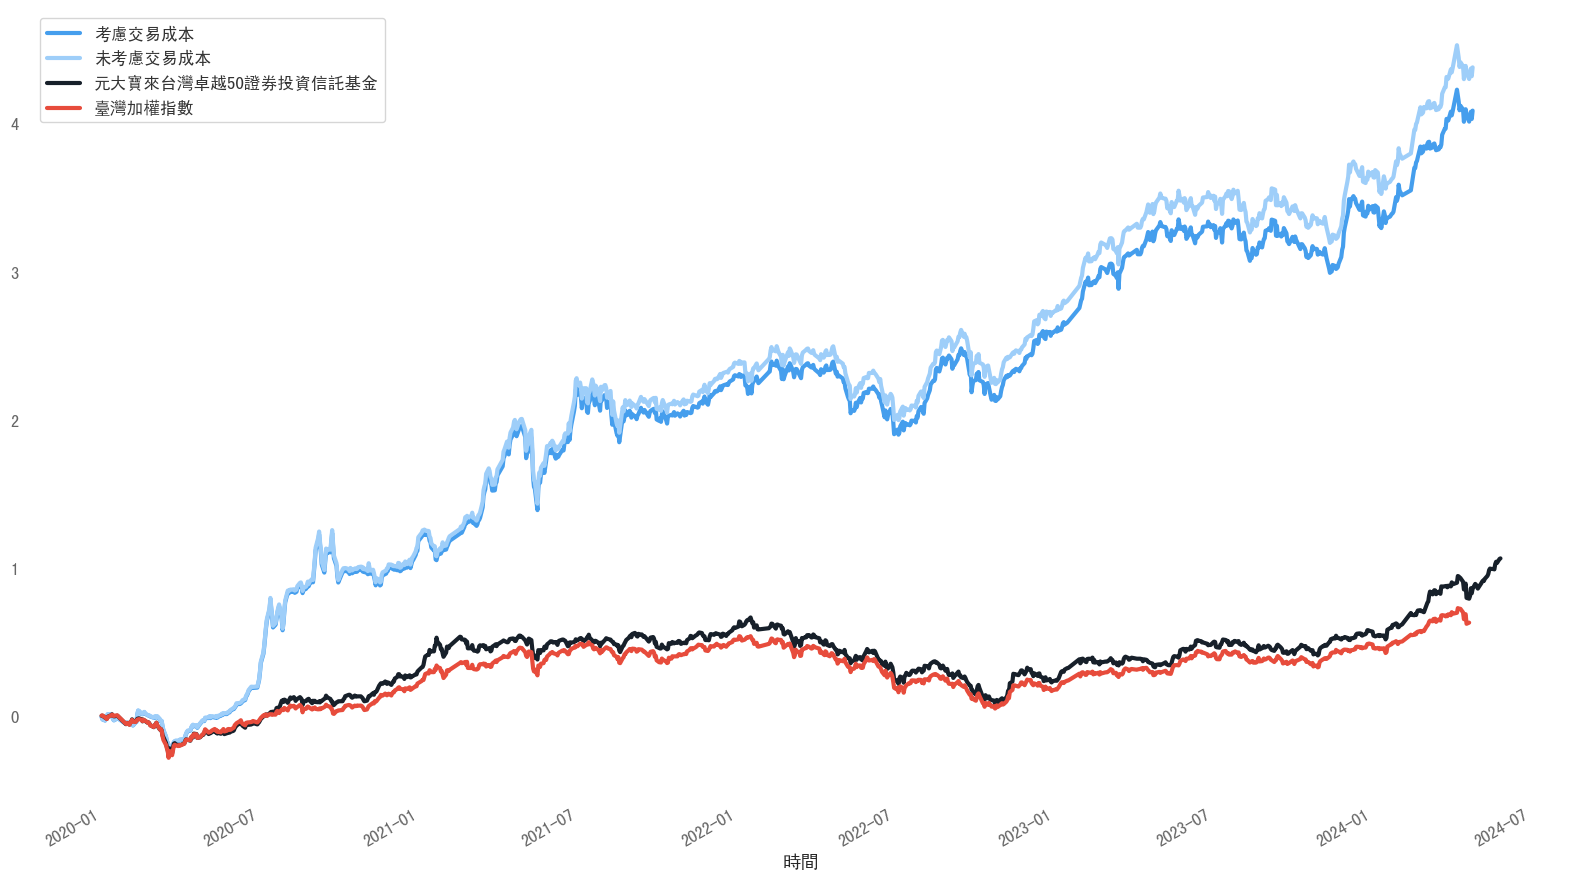

In [26]:
title = 'Black-Litterman模型之累積報酬'
df_real.index = pd.to_datetime(df_real.index)
colors = ['#459EED', '#9ECEF9', '#17202A','#E74C3C']
((1+df_real['2020':]).cumprod()-1).plot(label = '考慮交易成本', lw = 3, figsize = (16,9), color = colors[0])
df_bl.index = pd.to_datetime(df_bl.index)
((1+df_bl['2020':]).cumprod()-1).plot(label = '未考慮交易成本',lw = 3, color = colors[1])
((1+benchmark['2020':]).cumprod()-1).plot(label = '元大寶來台灣卓越50證券投資信託基金', lw = 3, color = colors[2])
((1+market_return['2020':]).cumprod()-1).plot(label = '臺灣加權指數', lw = 3, color = colors[3])

plt.xlabel('時間')
plt.grid(False)
plt.plot(title = title)
plt.legend()
plt.tight_layout()
plt.savefig(title+'.png')
plt.show()